# spatialpandas
Pandas and Dask extensions for vectorized spatial and geometric operations using numba, initially focused on the needs of data visualization libraries.

## Goal
The goal of spatialpandas is to provide a foundation for implementing custom vectorized geometric algorithms using numba or cython.  The initial motivation for the project was to support data visualization libraries.  Datashader, for example, builds on spatialpandas to support vectorized polygon rendering using numba.

## Comparison to geopandas
This project shares some of the goals (and some of the API) of the [`geopandas`](http://geopandas.org/) project. However, unlike `geopandas`, `spatialpandas` is not focused on geographic functionality. Instead, this project is focused on geometric use-cases and is explicitly independent of what space these spatial data structures and operations cover.  As such, `spatialpandas` has no dependencies on the traditional geographic stack (GDAL, fiona, GEOS, etc.).  Instead, it is built solely on top of general-purpose SciPy and PyData libraries and tools, which means that is should be easily installable using Conda or pip without any trickly binary-compatibility issues.

All algorithms are implemented in pure Python, which is then compiled to machine code at runtime with Numba. To support scaling to large problems, operations can run distributed and/or out of core using Dask.

## Future direction
In the future, this library could grow to support most of the *geometric* operations offered by `geopandas`.  It could also be extended to include 3-dimensional geometric primitives and operations.

## Geometry Extension Arrays
`spatialpandas` provides [pandas extension arrays](https://pandas.pydata.org/pandas-docs/stable/development/extending.html#extension-types) for storing arrays of geometry objects as DataFrame columns.  Unlike `geopandas`, where a geometry column may contain a mix of geometry types, all elements of a `spatialpandas` geometry array must be of the same geometry type.

In [1]:
from spatialpandas.geometry import (
    PointArray, MultiPointArray, LineArray,
    MultiLineArray, PolygonArray, MultiPolygonArray
)
%matplotlib inline

### PointArray
The `PointArray` stores the coordinates of a single point per element.  A `PointArray` can be constructed from several data structures:

A 2D list or array with two columns, the first column containing the x coordinates and the second the y coordinates.

In [2]:
point_array = PointArray([
    [1, 2],
    [3, 4],
    [5, 6],
])
point_array

<PointArray>
[Point([1, 2]), Point([3, 4]), Point([5, 6])]
Length: 3, dtype: point[int64]

A 1D list or array of the interleaved x and y coordinates of each point

In [3]:
point_array = PointArray([
    1, 2,
    3, 4,
    5, 6,
])
point_array

<PointArray>
[Point([1, 2]), Point([3, 4]), Point([5, 6])]
Length: 3, dtype: point[int64]

A tuple of two 1D lists or arrays, the first containing the x coordinates and the second the y coordinates.

In [4]:
point_array = PointArray(
    ([1, 3, 5], [2, 4, 6])
)
point_array

<PointArray>
[Point([1, 2]), Point([3, 4]), Point([5, 6])]
Length: 3, dtype: point[int64]

The x and y coordinates of a `PointArray` can be accessed using the `x` and `y` properties.

In [5]:
point_array.x

array([1., 3., 5.])

In [6]:
point_array.y

array([2., 4., 6.])

All coordinates can be accessed as a single array of interleaved x and y coordinates using the `flat_values` property.

In [7]:
point_array.flat_values

array([1, 2, 3, 4, 5, 6])

### MultiPointArray
A `MultiPointArray` stores the coordinates of zero or more points per element. A `MultiPointArray` is constructed from a list of lists, where the inner lists contain the interleaved x and y coordinates of the points in that element.

In [8]:
multipoint_array = MultiPointArray([
    [1, 2, 3, 4, 5, 6],
    [7, 8, 9, 10],
])
multipoint_array

<MultiPointArray>
[MultiPoint([1, 2, 3, 4, 5, 6]), MultiPoint([7, 8, 9, 10])]
Length: 2, dtype: multipoint[int64]

All of the coordinates can be accessed as a single flat array of interleaved x and y coordinates using the `buffer_values` property.

In [9]:
multipoint_array.buffer_values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

A length one tuple with an array of indices into `buffer_values` that separate the coordinates of individual elements is available as the `buffer_offsets` property.

In [10]:
multipoint_array.buffer_offsets

(array([ 0,  6, 10], dtype=uint32),)

### LineArray
A `LineArray` stores the coordinates of one line per element. Like the `MultiPointArray`, a `LineArray` is constructed from a list of lists, where the inner lists contain the interleaved x and y coordinates of the vertices of the line in that element.

In [11]:
line_array = LineArray([
    [1, 2, 3, 4, 5, 6],
    [7, 8, 9, 10],
])
line_array

<LineArray>
[Line([1, 2, 3, 4, 5, 6]), Line([7, 8, 9, 10])]
Length: 2, dtype: line[int64]

### MultiLineArray
A `MultiLineArray` stores the coordinates of zero or more lines per element. A `MultiLineArray` is constructed from a doubly nested list of the interleaved x and y coordinates.

In [12]:
multiline_array = MultiLineArray([
    [[1, 2, 3, 4, 5, 6], [7, 8, 9, 10]],
    [[11, 12]]
])
multiline_array

<MultiLineArray>
[MultiLine([[1, 2, 3, 4, 5, 6], [7, 8, 9, 10]]), MultiLine([[11, 12]])]
Length: 2, dtype: multiline[int64]

All of the coordinates can be accessed as a single flat array of interleaved x and y coordinates using the `buffer_values` property.

In [13]:
multiline_array.buffer_values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

A tuple of arrays of indices into `buffer_values` that separate the coordinates of individual lines and multi-line elements are available as the `buffer_offsets` property.

In [14]:
multiline_array.buffer_offsets

(array([0, 2, 3], dtype=uint32), array([ 0,  6, 10, 12], dtype=uint32))

### PolygonArray
A `PolygonArray` stores the coordinates of one polygon (with zero or more holes) per element. Like the `MultiLineArray`, a `PolygonArray` is constructed from a doubly nested list of interleaved x and y coordinates. Each inner list contains the interleaved x and y coordinates of a closed ring. The first ring of each element represents the filled polygon outline and should be in a counter-clockwise order.  The following rings, if any, represent holes in the polygon and should be in a clockwise order.

In [15]:
# Square from (0, 0) to (1, 1) in CCW order
outline0 = [0, 0, 1, 0, 1, 1, 0, 1, 0, 0]

# Square from (2, 2) to (5, 5) in CCW order
outline1 = [2, 2, 5, 2, 5, 5, 2, 5, 2, 2]

# Triangle hole in CW order
hole1 = [3, 3, 4, 3, 3, 4, 3, 3]

polygon_array = PolygonArray([
    [outline0],
    [outline1, hole1]
])
polygon_array

<PolygonArray>
[Polygon([[0, 0, 1, 0, 1, 1, 0, 1, 0, 0]]), Polygon([[2, 2, 5, 2, 5, 5, 2, 5, 2, 2], [3, 3, 4, 3, 3, 4, 3, 3]])]
Length: 2, dtype: polygon[int64]

All of the coordinates can be accessed as a single flat array of interleaved x and y coordinates using the `buffer_values` property.

In [16]:
polygon_array.buffer_values

array([0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 2, 2, 5, 2, 5, 5, 2, 5, 2, 2, 3, 3,
       4, 3, 3, 4, 3, 3])

A tuple of arrays of indices into `buffer_values` that separate the coordinates of individual rings and polygon elements is available as the `buffer_offsets` property.

In [17]:
polygon_array.buffer_offsets

(array([0, 1, 3], dtype=uint32), array([ 0, 10, 20, 28], dtype=uint32))

### MultiPolygonArray
A `MultiPolygonArray` stores the coordinates of one or more multi-polygons per element, where a multi-polygon consists of zero or more polygons that may each have zero or more holes.  The `MultiPolygonArray` adds one additional level of nesting compared to the `PolygonArray`.

In [18]:
# Triangle hole in CW order
outline3 = [3, 1, 4, 1, 3, 2, 3, 1]

multipolygon_array = MultiPolygonArray([
    [[outline0], [outline1, hole1]],
    [[outline3]]
])
multipolygon_array

<MultiPolygonArray>
[MultiPolygon([[[0, 0, 1, 0, 1, 1, 0, 1, 0, 0]], [[2, 2, 5, 2, 5, 5, 2, 5, 2, 2], [3, 3, 4, 3, 3, 4, 3, 3]]]), MultiPolygon([[[3, 1, 4, 1, 3, 2, 3, 1]]])]
Length: 2, dtype: multipolygon[int64]

In [19]:
multipolygon_array.buffer_values

array([0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 2, 2, 5, 2, 5, 5, 2, 5, 2, 2, 3, 3,
       4, 3, 3, 4, 3, 3, 3, 1, 4, 1, 3, 2, 3, 1])

In [20]:
multipolygon_array.buffer_offsets

(array([0, 2, 3], dtype=uint32),
 array([0, 1, 3, 4], dtype=uint32),
 array([ 0, 10, 20, 28, 36], dtype=uint32))

## spatialpandas GeoSeries and GeoDataFrame
While `spatialpandas` geometry arrays can be stored in standard pandas `Series` and `DataFrame` objects, additional functionality is provided by the `GeoSeries` and `GeoDataFrame` subclasses.  These classes are designed to implement a subset of the API of the `GeoSeries` and `GeoDataFrame` classes provided by the `geopandas` library.

In [21]:
from spatialpandas import GeoSeries, GeoDataFrame

In [22]:
geo_series = GeoSeries(multipoint_array)
geo_series

0    MultiPoint([1, 2, 3, 4, 5, 6])
1         MultiPoint([7, 8, 9, 10])
dtype: multipoint[int64]

In [23]:
geo_df = GeoDataFrame({
    'multipoint': multiline_array,
    'line': line_array,
    'multiline': multiline_array,
    'polygon': polygon_array,
    'multipolygon': multipolygon_array
})
geo_df

multipoint                      line  \
0  MultiLine([[1, 2, 3, 4, 5, 6], [7, 8, 9, 10]])  Line([1, 2, 3, 4, 5, 6])   
1                           MultiLine([[11, 12]])       Line([7, 8, 9, 10])   

                                        multiline  \
0  MultiLine([[1, 2, 3, 4, 5, 6], [7, 8, 9, 10]])   
1                           MultiLine([[11, 12]])   

                                             polygon  \
0          Polygon([[0, 0, 1, 0, 1, 1, 0, 1, 0, 0]])   
1  Polygon([[2, 2, 5, 2, 5, 5, 2, 5, 2, 2], [3, 3...   

                                        multipolygon  
0  MultiPolygon([[[0, 0, 1, 0, 1, 1, 0, 1, 0, 0]]...  
1         MultiPolygon([[[3, 1, 4, 1, 3, 2, 3, 1]]])

## GeoPandas conversions
`GeoSeries` and `GeoDataFrame` objects from `geopandas` can be converted to `spatialpandas` objects by passing them to the constructor of the `spatialpandas` equivalent.

Here is an example of loading the `naturalearth_lowres` dataset using `geopandas` as a `GeoDataFrame`, and then converting it to a `spatialpandas` `GeoDataFrame`.

> Note: The following examples require the `geopandas`, `matplotlib`, and `descartes` packages, which are not automatically installed with `spatialpandas`. These can be installed using pip...
```
$ pip install geopandas matplotlib descartes
```
> or conda...
```
$ conda install geopandas matplotlib descartes
```

In [24]:
import geopandas

world_gp = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)
world_gp = world_gp.sort_values('name').reset_index(drop=True)
world_gp = world_gp[['pop_est', 'continent', 'name', 'geometry']]
world_gp

pop_est   continent         name  \
0    34124811        Asia  Afghanistan   
1     3047987      Europe      Albania   
2    40969443      Africa      Algeria   
3    29310273      Africa       Angola   
4        4050  Antarctica   Antarctica   
..        ...         ...          ...   
172    603253      Africa    W. Sahara   
173  28036829        Asia        Yemen   
174  15972000      Africa       Zambia   
175  13805084      Africa     Zimbabwe   
176   1467152      Africa     eSwatini   

                                              geometry  
0    POLYGON ((66.51861 37.36278, 67.07578 37.35614...  
1    POLYGON ((21.02004 40.84273, 20.99999 40.58000...  
2    POLYGON ((-8.68440 27.39574, -8.66512 27.58948...  
3    MULTIPOLYGON (((12.99552 -4.78110, 12.63161 -4...  
4    MULTIPOLYGON (((-48.66062 -78.04702, -48.15140...  
..                                                 ...  
172  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
173  POLYGON ((52.00001 19.00000, 52.78218 17.34974...  
174  POLYGON ((30.74001 -8.34001, 31.15775 -8.59458...  
175  POLYGON ((31.19141 -22.25151, 30.65987 -22.151...  
176  POLYGON ((32.07167 -26.73382, 31.86806 -27.177...  

[177 rows x 4 columns]

In [25]:
world_df = GeoDataFrame(world_gp)
world_df

pop_est   continent         name  \
0    34124811        Asia  Afghanistan   
1     3047987      Europe      Albania   
2    40969443      Africa      Algeria   
3    29310273      Africa       Angola   
4        4050  Antarctica   Antarctica   
..        ...         ...          ...   
172    603253      Africa    W. Sahara   
173  28036829        Asia        Yemen   
174  15972000      Africa       Zambia   
175  13805084      Africa     Zimbabwe   
176   1467152      Africa     eSwatini   

                                              geometry  
0    MultiPolygon([[[66.51860680528867, 37.36278432...  
1    MultiPolygon([[[21.0200403174764, 40.842726955...  
2    MultiPolygon([[[-8.684399786809053, 27.3957441...  
3    MultiPolygon([[[12.995517205465177, -4.7811032...  
4    MultiPolygon([[[-48.66061601418252, -78.047018...  
..                                                 ...  
172  MultiPolygon([[[-8.665589565454809, 27.6564258...  
173  MultiPolygon([[[52.00000980002224, 19.00000336...  
174  MultiPolygon([[[30.740009731422095, -8.3400059...  
175  MultiPolygon([[[31.19140913262129, -22.2515096...  
176  MultiPolygon([[[32.07166548028107, -26.7338200...  

[177 rows x 4 columns]

A `spatialpandas` `GeoDataFrame` or `GeoSeries` can be converted to `geopandas` using the `to_geopandas` method.

In [26]:
world_df.iloc[[4, 2, 0]].to_geopandas()

pop_est   continent         name  \
4      4050  Antarctica   Antarctica   
2  40969443      Africa      Algeria   
0  34124811        Asia  Afghanistan   

                                            geometry  
4  MULTIPOLYGON (((-48.66062 -78.04702, -48.66062...  
2  MULTIPOLYGON (((-8.68440 27.39574, -4.92334 24...  
0  MULTIPOLYGON (((66.51861 37.36278, 66.21738 37...

## Visualization

### Visualizing geometry elements using shapely
Individual elements of a `spatialpandas` geometry array can be converted to `shapely` shapes using the `to_shapely` method, and shapely objects automatically display themselves in the Jupyter notebook.

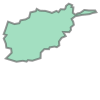

In [27]:
world_df.geometry[0].to_shapely()

### Visualizing GeoSeries with matplotlib using geopandas
A `spatialpandas` `GeoSeries` can be converted to a `geopandas` `GeoSeries` using the `to_geopandas` method, and `geopandas` `GeoSeries` objects can be visualized with `matplotlib` using the `plot` method.

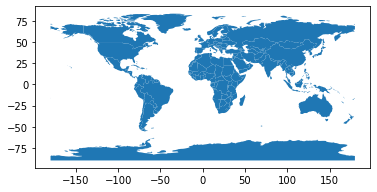

In [28]:
world_df.geometry.to_geopandas().plot()

### Visualizing GeoSeries with Datashader
A `spatialpandas` `GeoDataFrame` can be visualized with `datashader`.  Here is an example of visualizing a multi-polygon `GeoSeries` using `datashader`. In this case, the polygons are shaded to reflect the estimated population of each country.

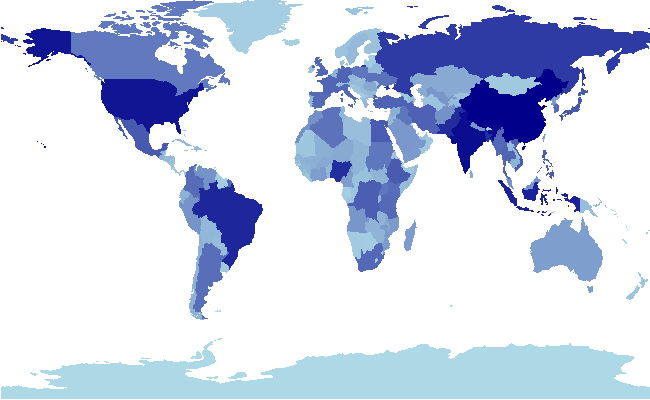

In [29]:
import datashader as ds
cvs = ds.Canvas(plot_width=650, plot_height=400)
agg = cvs.polygons(world_df, geometry='geometry', agg=ds.mean('pop_est'))
ds.transfer_functions.shade(agg)

### Visualizing geometry arrays interactively with Datashader and HoloViews
By combining `datashader` and a `HoloViews` `DynamicMap`, `spatialpandas` geometry arrays can be rendered interactively.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
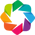

In [30]:
import holoviews as hv
hv.extension("bokeh")

In [31]:
def callback(x_range, y_range):
    cvs = ds.Canvas(plot_width=650, plot_height=400, x_range=x_range, y_range=y_range)
    agg = cvs.polygons(world_df, geometry='geometry', agg=ds.mean('pop_est'))
    return hv.Image(agg).opts(cmap="viridis").opts(width=650, height=400)

hv.DynamicMap(
    callback, streams=[hv.streams.RangeXY()]
)

:DynamicMap   []
   :Image   [x,y]   (z)

## Spatial selection
As with `geopandas`, the `spatialpandas` `GeoSeries` and `GeoDataFrame` provide a spatial indexer, `cx`, that can be used to select the entries that reside in a particular spatial region.

Here is an example of using the `cx` indexer to select those countries that reside, at least partially, in the southern hemisphere.

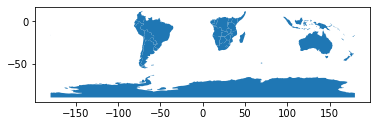

In [32]:
selected_world_df = world_df.geometry.cx[:, :0]
selected_world_df.to_geopandas().plot()

## Length and area calculations
`spatialpandas` provides `GeoSeries` `length` and `area` properties to compute the length and area of each geometry element.

In [33]:
world_df['area'] = world_df.geometry.area
world_df['length'] = world_df.geometry.length
world_df

pop_est   continent         name  \
0    34124811        Asia  Afghanistan   
1     3047987      Europe      Albania   
2    40969443      Africa      Algeria   
3    29310273      Africa       Angola   
4        4050  Antarctica   Antarctica   
..        ...         ...          ...   
172    603253      Africa    W. Sahara   
173  28036829        Asia        Yemen   
174  15972000      Africa       Zambia   
175  13805084      Africa     Zimbabwe   
176   1467152      Africa     eSwatini   

                                              geometry         area  \
0    MultiPolygon([[[66.51860680528867, 37.36278432...    63.593500   
1    MultiPolygon([[[21.0200403174764, 40.842726955...     3.185163   
2    MultiPolygon([[[-8.684399786809053, 27.3957441...   213.602772   
3    MultiPolygon([[[12.995517205465177, -4.7811032...   103.599439   
4    MultiPolygon([[[-48.66061601418252, -78.047018...  6028.836194   
..                                                 ...          ...   
172  MultiPolygon([[[-8.665589565454809, 27.6564258...     8.603984   
173  MultiPolygon([[[52.00000980002224, 19.00000336...    38.475618   
174  MultiPolygon([[[30.740009731422095, -8.3400059...    62.789498   
175  MultiPolygon([[[31.19140913262129, -22.2515096...    32.280371   
176  MultiPolygon([[[32.07166548028107, -26.7338200...     1.639983   

          length  
0      46.043309  
1       8.146598  
2      65.867357  
3      54.986811  
4    1041.993521  
..           ...  
172    27.662143  
173    29.050429  
174    44.450846  
175    23.632987  
176     4.763277  

[177 rows x 6 columns]

## Parquet support
`spatialpandas` `GeoDataFrames` containing geometry arrays can be saved and loaded from `parquet` files using the `to_parquet` and `read_parquet` methods from the `spatialpandas.io` module.

In [34]:
from spatialpandas.io import to_parquet, read_parquet

In [35]:
to_parquet(world_df, 'world.parq')

In [36]:
read_parquet('world.parq')

pop_est   continent         name  \
0    34124811        Asia  Afghanistan   
1     3047987      Europe      Albania   
2    40969443      Africa      Algeria   
3    29310273      Africa       Angola   
4        4050  Antarctica   Antarctica   
..        ...         ...          ...   
172    603253      Africa    W. Sahara   
173  28036829        Asia        Yemen   
174  15972000      Africa       Zambia   
175  13805084      Africa     Zimbabwe   
176   1467152      Africa     eSwatini   

                                              geometry         area  \
0    MultiPolygon([[[66.51860680528867, 37.36278432...    63.593500   
1    MultiPolygon([[[21.0200403174764, 40.842726955...     3.185163   
2    MultiPolygon([[[-8.684399786809053, 27.3957441...   213.602772   
3    MultiPolygon([[[12.995517205465177, -4.7811032...   103.599439   
4    MultiPolygon([[[-48.66061601418252, -78.047018...  6028.836194   
..                                                 ...          ...   
172  MultiPolygon([[[-8.665589565454809, 27.6564258...     8.603984   
173  MultiPolygon([[[52.00000980002224, 19.00000336...    38.475618   
174  MultiPolygon([[[30.740009731422095, -8.3400059...    62.789498   
175  MultiPolygon([[[31.19140913262129, -22.2515096...    32.280371   
176  MultiPolygon([[[32.07166548028107, -26.7338200...     1.639983   

          length  
0      46.043309  
1       8.146598  
2      65.867357  
3      54.986811  
4    1041.993521  
..           ...  
172    27.662143  
173    29.050429  
174    44.450846  
175    23.632987  
176     4.763277  

[177 rows x 6 columns]

## Dask support
`spatialpandas` geometry arrays can be processed in parallel by Dask using the `DaskGeoSeries` and `DaskGeoDataFrame` classes from the `spatialpandas.dask` module.

### Construction
Dask will automatically create a `DaskGeoDataFrame` when a `GeoDataFrame` is passed to the `dask.dataframe.from_pandas` function.

In [37]:
import dask.dataframe as dd
world_ddf = dd.from_pandas(world_df, npartitions=20)
print(type(world_ddf))
world_ddf

<class 'spatialpandas.dask.DaskGeoDataFrame'>


Dask DaskGeoDataFrame Structure:
               pop_est continent    name               geometry     area   length
npartitions=20                                                                   
0                int64    object  object  multipolygon[float64]  float64  float64
9                  ...       ...     ...                    ...      ...      ...
...                ...       ...     ...                    ...      ...      ...
171                ...       ...     ...                    ...      ...      ...
176                ...       ...     ...                    ...      ...      ...
Dask Name: from_pandas, 20 tasks

### Pack partitions
Dask parallelizes data frame operations by grouping collections of the DataFrame's rows into separate partitions.  In addition, the `DaskGeoDataFrame` keeps track of the spatial extent of all geometry objects in each partition.  Many spatial operations, including spatial indexing with `cx`, can be performed more efficiently if geometry objects in each partition are close together, and if there is minimal overlap in the spatial extent of different partitions.

The `DaskGeoDataFrame.pack_partitions` method can be used to create a new data frame with spatially optimized partitions using a [Hilbert R-tree](https://en.wikipedia.org/wiki/Hilbert_R-tree) packing method.  This operation involves a full shuffle of the Dask data frame and can be computationally expensive, so it's a good idea to save the resulting packed `DaskGeoDataFrame` to a parquet file for later use. See the *Distributed parquet support* section below for more information.

To demonstrate the effect of packing, we will plot the countries dataset using Datashader before and after packing. In each case, the dataset is grouped into 20 partitions. The `plot_partitions` helper function below plots the dataset, with each country colored by its partition.

The original `world_df` `GeoDataFrame` that was used to create the `world_ddf` `DaskGeoDataFrame` was sorted in alphabetical order by country name. Not surprisingly, this ordering does a poor job of grouping nearby countries into the same partition.  Instead, we see that countries of each color (i.e. partition) are scattered across the world.

In [38]:
import numpy as np
import pandas as pd
def plot_partitions(ddf):
    # Get divisions array
    divs = np.array(ddf.divisions)[:-1]
    
    # Add categorical "partition" column
    ddf2 = ddf.map_partitions(
        lambda df: df.assign(
            partition=pd.Categorical(np.searchsorted(divs, df.index, side="right"))
        )
    ).compute()
    
    # Create Datashader image, coloring countries by partition
    cvs = ds.Canvas(plot_width=650, plot_height=400)
    agg = cvs.polygons(ddf2, geometry='geometry', agg=ds.count_cat('partition'))
    return ds.transfer_functions.shade(agg)

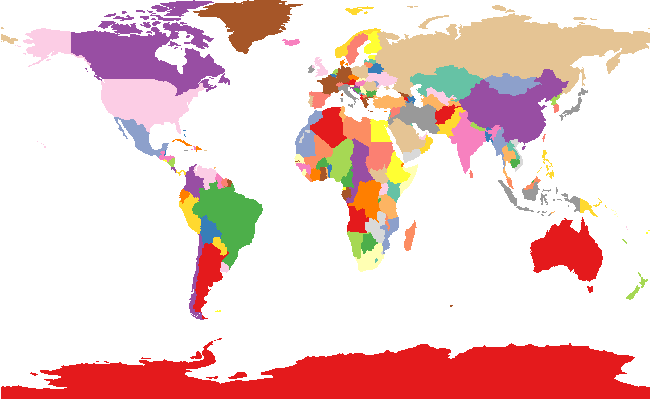

In [39]:
plot_partitions(world_ddf)

After packing, however, the partitions contain countries that are much more localized.

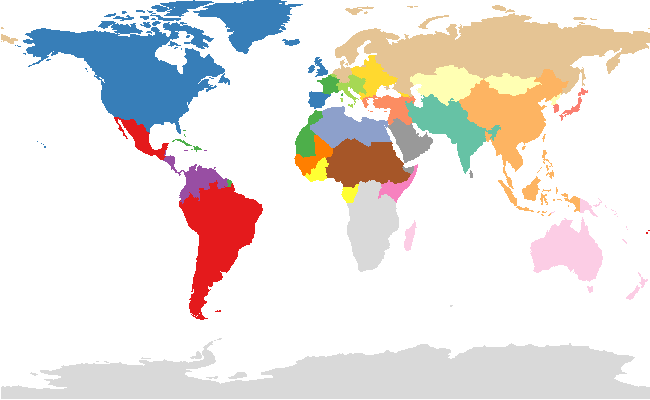

In [40]:
world_ddf_packed = world_ddf.pack_partitions(npartitions=20)
plot_partitions(world_ddf_packed)

### Distributed spatial selection
Like `GeoDataFrame`, the `DaskGeoDataFrame` class supports spatial selection using the `cx` indexer.

Here is an example of using the `cx` indexer to select the countries in the southern region of Africa.

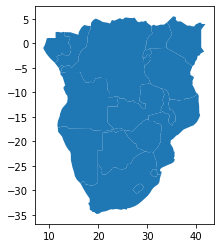

In [41]:
southern_aftrica = world_ddf.cx[-15:40, -60:0]
southern_aftrica.geometry.compute().to_geopandas().plot()

### Distributed parquet support
`DaskGeoDataFrame` objects can be written to parquet files using the `to_parquet` method and read using the `spatialpandas.io.read_parquet_dask` function.

The `DaskGeoDataFrame.to_parquet` method stores the bounding box extents of each partition as parquet metadata, and the `read_parquet_dask` function loads this metadata. This makes it possible to perform efficient spatial queries on datasets without the need to first load all of the partitions into memory to compute their spatial extents.

In [42]:
from spatialpandas.io import read_parquet_dask
world_ddf_packed.to_parquet('world_packed.parq')

In [43]:
world_packed_loaded = read_parquet_dask('world_packed.parq')
world_packed_loaded

Dask DaskGeoDataFrame Structure:
               pop_est continent    name               geometry     area   length
npartitions=20                                                                   
116503           int64    object  object  multipolygon[float64]  float64  float64
375903             ...       ...     ...                    ...      ...      ...
...                ...       ...     ...                    ...      ...      ...
868958             ...       ...     ...                    ...      ...      ...
957014             ...       ...     ...                    ...      ...      ...
Dask Name: lambda, 40 tasks